In [1]:
%load_ext autoreload
%reload_ext autoreload
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


# Henon Hieles Runner
> Train and analyze performance on henon hieles dataset

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import jax.experimental.mesh_utils as mesh_utils
import jax.sharding as sharding

from copy import deepcopy
import logging
from tqdm.notebook import trange
from functools import partial
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from jaxDiversity.dataloading import HHDataset, NumpyLoader
from jaxDiversity.utilclasses import InnerConfig, OuterConfig
from jaxDiversity.mlp import (
    mlp_afunc,
    MultiActMLP,
    init_linear_weight,
    xavier_normal_init,
)
from jaxDiversity.baseline import compute_loss as compute_loss_baseline
from jaxDiversity.hnn import compute_loss as compute_loss_hnn
from jaxDiversity.loops import inner_opt, outer_opt

In [4]:
sns.set_theme(
    context="paper",
    style="white",
    palette="colorblind",
    font_scale=1,
    color_codes=True,
    rc={"text.usetex": True},
)

In [5]:
# Configure the logger
logging.basicConfig(level=logging.INFO)

In [6]:
# run on cpu
jax.config.update("jax_platform_name", "cpu")
logging.info(f"jax backend: {jax.lib.xla_bridge.get_backend().platform}")

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA Host
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:root:jax backend: cpu


### Test dataset access

In [7]:
TEST_TRAIN_SPLIT = 0.8
data_path = "../data/HenonHeiles/"
train_dataset = HHDataset(data_path, train=True)
test_dataset = HHDataset(data_path, train=False)


train_dataloader = NumpyLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = NumpyLoader(test_dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))

assert x.shape == (8, 4)
assert y.shape == (8, 4)

### test inner loop

In [8]:
dev_inner_config = InnerConfig(
    test_train_split=0.8,
    input_dim=4,
    output_dim=4,
    hidden_layer_sizes=[18],
    batch_size=64,
    epochs=2,
    lr=1e-3,
    mu=0.9,
    n_fns=2,
    l2_reg=1e-1,
    seed=42,
)
key = jax.random.PRNGKey(dev_inner_config.seed)
model_key, init_key = jax.random.split(key)
afuncs = [lambda x: x**2, lambda x: x]
data_path = "../data/HenonHeiles/"
train_dataset = HHDataset(data_path, train=True)
test_dataset = HHDataset(data_path, train=False)
train_dataloader = NumpyLoader(
    train_dataset, batch_size=dev_inner_config.batch_size, shuffle=True
)
test_dataloader = NumpyLoader(
    test_dataset, batch_size=dev_inner_config.batch_size, shuffle=True
)
opt = optax.rmsprop(
    learning_rate=dev_inner_config.lr,
    momentum=dev_inner_config.mu,
    decay=dev_inner_config.l2_reg,
)
model = MultiActMLP(
    dev_inner_config.input_dim,
    dev_inner_config.output_dim,
    dev_inner_config.hidden_layer_sizes,
    model_key,
    bias=False,
)
model = init_linear_weight(model, xavier_normal_init, init_key)
logging.info("Baseline NN inner loop test")
baselineNN, opt_state, inner_results = inner_opt(
    model=model,
    train_data=train_dataloader,
    test_data=test_dataloader,
    afuncs=afuncs,
    opt=opt,
    loss_fn=compute_loss_baseline,
    config=dev_inner_config,
    training=True,
    verbose=True,
)

INFO:root:Baseline NN inner loop test
INFO:root:Epoch 000 | Train Loss: 1.3643e-04 | Test Loss: 4.3036e-05 | Grad Norm: 8.8691e-03
INFO:root:Epoch 001 | Train Loss: 6.7788e-05 | Test Loss: 4.1592e-05 | Grad Norm: 5.0495e-03


In [9]:
dev_inner_config = InnerConfig(
    test_train_split=0.8,
    input_dim=4,
    output_dim=1,
    hidden_layer_sizes=[18],
    batch_size=64,
    epochs=2,
    lr=1e-3,
    mu=0.9,
    n_fns=2,
    l2_reg=1e-1,
    seed=42,
)
key = jax.random.PRNGKey(dev_inner_config.seed)
model_key, init_key = jax.random.split(key)
afuncs = [lambda x: x**2, lambda x: x]
data_path = "../data/HenonHeiles/"
train_dataset = HHDataset(data_path, train=True)
test_dataset = HHDataset(data_path, train=False)
train_dataloader = NumpyLoader(
    train_dataset, batch_size=dev_inner_config.batch_size, shuffle=True
)
test_dataloader = NumpyLoader(
    test_dataset, batch_size=dev_inner_config.batch_size, shuffle=True
)
opt = optax.rmsprop(
    learning_rate=dev_inner_config.lr,
    momentum=dev_inner_config.mu,
    decay=dev_inner_config.l2_reg,
)
model = MultiActMLP(
    dev_inner_config.input_dim,
    dev_inner_config.output_dim,
    dev_inner_config.hidden_layer_sizes,
    model_key,
    bias=False,
)
model = init_linear_weight(model, xavier_normal_init, init_key)
logging.info("Hamiltonian NN inner loop test")
HNN, opt_state, inner_results = inner_opt(
    model=model,
    train_data=train_dataloader,
    test_data=test_dataloader,
    afuncs=afuncs,
    opt=opt,
    loss_fn=compute_loss_hnn,
    config=dev_inner_config,
    training=True,
    verbose=True,
)

INFO:root:Hamiltonian NN inner loop test
INFO:root:Epoch 000 | Train Loss: 2.0343e-02 | Test Loss: 1.6660e-02 | Grad Norm: 1.2677e-01
INFO:root:Epoch 001 | Train Loss: 1.9603e-02 | Test Loss: 1.5217e-02 | Grad Norm: 1.2419e-01


### test outer loop

In [11]:
# test outer_opt Baseline
inner_config = InnerConfig(
    test_train_split=0.8,
    input_dim=4,
    output_dim=4,
    hidden_layer_sizes=[18],
    batch_size=64,
    epochs=2,
    lr=1e-3,
    mu=0.9,
    n_fns=2,
    l2_reg=1e-1,
    seed=42,
)
outer_config = OuterConfig(
    input_dim=1,
    output_dim=1,
    hidden_layer_sizes=[18],
    batch_size=1,
    steps=2,
    print_every=1,
    lr=1e-3,
    mu=0.9,
    seed=24,
)
data_path = "../data/HenonHeiles/"
train_dataset = HHDataset(data_path, train=True)
test_dataset = HHDataset(data_path, train=False)
train_dataloader = NumpyLoader(
    train_dataset, batch_size=inner_config.batch_size, shuffle=True
)
test_dataloader = NumpyLoader(
    test_dataset, batch_size=inner_config.batch_size, shuffle=True
)
opt = optax.rmsprop(
    learning_rate=inner_config.lr, momentum=inner_config.mu, decay=inner_config.l2_reg
)
meta_opt = optax.rmsprop(learning_rate=outer_config.lr, momentum=outer_config.mu)
logging.info("Baseline NN outer loop test")
baseline_acts, baseline_stats = outer_opt(
    train_dataloader,
    test_dataloader,
    compute_loss_baseline,
    inner_config,
    outer_config,
    opt,
    meta_opt,
    save_path=None,
)

INFO:root:Baseline NN outer loop test


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:root:Step 000 | Train Loss: 5.9103e-04 | Test Loss: 4.9557e-04 | Grad Norm: 3.5986e-02
INFO:root:Step 001 | Train Loss: 6.3934e-04 | Test Loss: 6.3253e-04 | Grad Norm: 1.1944e-01


In [12]:
# test outer_opt HNN
inner_config = InnerConfig(
    test_train_split=0.8,
    input_dim=4,
    output_dim=1,
    hidden_layer_sizes=[18],
    batch_size=64,
    epochs=2,
    lr=1e-3,
    mu=0.9,
    n_fns=2,
    l2_reg=1e-1,
    seed=42,
)
outer_config = OuterConfig(
    input_dim=1,
    output_dim=1,
    hidden_layer_sizes=[18],
    batch_size=1,
    steps=2,
    print_every=1,
    lr=1e-3,
    mu=0.9,
    seed=24,
)
data_path = "../data/HenonHeiles/"
train_dataset = HHDataset(data_path, train=True)
test_dataset = HHDataset(data_path, train=False)
train_dataloader = NumpyLoader(
    train_dataset, batch_size=inner_config.batch_size, shuffle=True
)
test_dataloader = NumpyLoader(
    test_dataset, batch_size=inner_config.batch_size, shuffle=True
)
opt = optax.rmsprop(
    learning_rate=inner_config.lr, momentum=inner_config.mu, decay=inner_config.l2_reg
)
meta_opt = optax.rmsprop(learning_rate=outer_config.lr, momentum=outer_config.mu)
logging.info("Hamiltonian NN outer loop test")
HNN_acts, HNN_stats = outer_opt(
    train_dataloader,
    test_dataloader,
    compute_loss_hnn,
    inner_config,
    outer_config,
    opt,
    meta_opt,
    save_path=None,
)

INFO:root:Hamiltonian NN outer loop test


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:root:Step 000 | Train Loss: 1.6710e-02 | Test Loss: 1.8629e-02 | Grad Norm: 2.4679e-02
INFO:root:Step 001 | Train Loss: 1.9475e-02 | Test Loss: 1.8421e-02 | Grad Norm: 1.7501e-02


### Run the experiments

In [13]:
inner_config = InnerConfig(
    test_train_split=0.8,
    input_dim=4,
    output_dim=1,
    hidden_layer_sizes=[100],
    batch_size=150,
    epochs=1,
    lr=2e-2,
    mu=0.6,
    n_fns=2,
    l2_reg=1e-1,
    seed=42,
)
outer_config = OuterConfig(
    input_dim=1,
    output_dim=1,
    hidden_layer_sizes=[20],
    batch_size=1,
    steps=100,
    print_every=10,
    lr=5e-2,
    mu=0.6,
    seed=24,
)
data_path = "../data/HenonHeiles/"
train_dataset = HHDataset(data_path, train=True)
test_dataset = HHDataset(data_path, train=False)
train_dataloader = NumpyLoader(
    train_dataset, batch_size=inner_config.batch_size, shuffle=True
)
test_dataloader = NumpyLoader(
    test_dataset, batch_size=inner_config.batch_size, shuffle=True
)
description = f"HNN_inner_epochs_{inner_config.epochs}_batch_{inner_config.batch_size}_outer_{outer_config.steps}_lr_{inner_config.lr}_n_{inner_config.n_fns}_seed_{inner_config.seed}"
# create folder to save output if it does not exist
save_path = f"../output/HenonHieles/{description}"
fig_path = f"../figures/HenonHieles/{description}"

opt = optax.rmsprop(
    learning_rate=inner_config.lr, momentum=inner_config.mu, decay=inner_config.l2_reg
)
meta_opt = optax.rmsprop(learning_rate=outer_config.lr, momentum=outer_config.mu)

if not os.path.exists(save_path):
    os.makedirs(save_path)
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

logging.info("Hamiltonian NN HenonHieles dataset")
HNN_acts, HNN_stats = outer_opt(
    train_dataloader,
    test_dataloader,
    compute_loss_hnn,
    inner_config,
    outer_config,
    opt,
    meta_opt,
    save_path=save_path,
)

INFO:root:Hamiltonian NN HenonHieles dataset


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Step 000 | Train Loss: 1.1646e-01 | Test Loss: 1.1359e-01 | Grad Norm: 6.2988e-01
INFO:root:Step 010 | Train Loss: 2.5117e-02 | Test Loss: 2.5783e-02 | Grad Norm: 1.2283e-01
INFO:root:Step 020 | Train Loss: 2.2432e-02 | Test Loss: 2.5139e-02 | Grad Norm: 5.4258e-02
INFO:root:Step 030 | Train Loss: 1.9624e-02 | Test Loss: 2.1446e-02 | Grad Norm: 5.9117e-02
INFO:root:Step 040 | Train Loss: 3.3965e-02 | Test Loss: 3.4752e-02 | Grad Norm: 2.0687e-01
INFO:root:Step 050 | Train Loss: 1.8332e-02 | Test Loss: 1.8869e-02 | Grad Norm: 1.4912e-02
INFO:root:Step 060 | Train Loss: 1.8511e-02 | Test Loss: 1.8330e-02 | Grad Norm: 2.5745e-02
INFO:root:Step 070 | Train Loss: 2.2921e-02 | Test Loss: 2.3929e-02 | Grad Norm: 2.0668e-01
INFO:root:Step 080 | Train Loss: 2.0997e-02 | Test Loss: 2.0164e-02 | Grad Norm: 8.3214e-02
INFO:root:Step 090 | Train Loss: 1.9735e-02 | Test Loss: 1.9968e-02 | Grad Norm: 9.6761e-02


In [14]:
# list attributes in the outer_results

for attr in dir(HNN_stats):
    if not attr.startswith("__"):
        print(f"{attr}")

grad_norm
inner_afuncs
inner_test_loss
train_loss


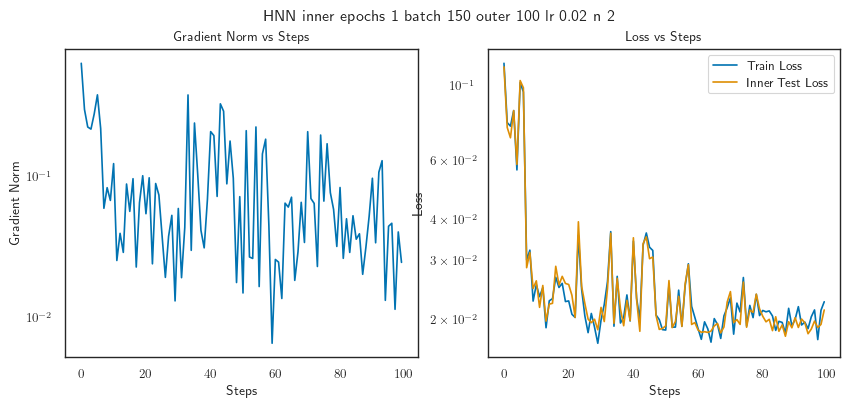

In [15]:
# plot HNN stats
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(HNN_stats.grad_norm)
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Gradient Norm")
ax[0].set_yscale("log")
ax[0].set_title("Gradient Norm vs Steps")

ax[1].plot(HNN_stats.train_loss, label="Train Loss")
ax[1].plot(HNN_stats.inner_test_loss, label="Inner Test Loss")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss")
ax[1].set_yscale("log")
ax[1].set_title("Loss vs Steps")
ax[1].legend()

plt.suptitle(f"{' '.join(description.split('_')[:-2])}")
plt.savefig(f"{fig_path}/stats.png")

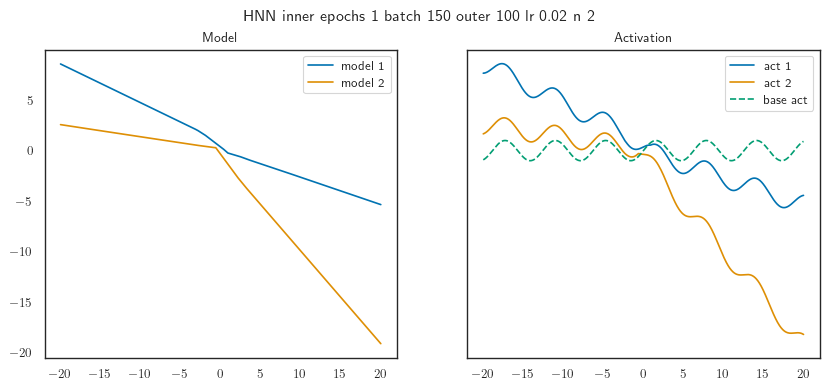

In [16]:
x = jnp.linspace(-20, 20, 1000).reshape(-1, 1)
model_output_arrays = []
act_arrays = []
for HNN_act in HNN_acts:
    model_output_arrays.append(jax.vmap(HNN_act)(x))
    act_arrays.append(mlp_afunc(x, HNN_act, jnp.sin))


fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)
for i, (model, act) in enumerate(zip(model_output_arrays, act_arrays)):
    axs[0].plot(x, model, label=f"model {i+1}")
    axs[1].plot(x, act, label=f"act {i+1}")

axs[1].plot(x, jnp.sin(x), "--", label="base act")

axs[0].set_title("Model")
axs[1].set_title("Activation")
axs[0].legend()
axs[1].legend()

plt.suptitle(f"{' '.join(description.split('_')[:-2])}")
plt.savefig(f"{fig_path}/activations.png")

In [17]:
### Train inner loop for large epochs and multiple runs
runs = 10
config = deepcopy(inner_config)
config.epochs = 5
config.seed = 0
jax.config.update("jax_platform_name", "gpu")
logging.info(f"jax backend: {jax.lib.xla_bridge.get_backend().platform}")
num_devices = len(jax.devices())
devices = mesh_utils.create_device_mesh((num_devices, 1))
shard = sharding.PositionalSharding(devices)

afuncs = [
    partial(mlp_afunc, model=outer_model, base_act=jnp.sin) for outer_model in HNN_acts
]
train_losses = []
test_losses = []
for i in trange(runs):
    key = jax.random.PRNGKey(config.seed + i)
    model = MultiActMLP(
        config.input_dim, config.output_dim, config.hidden_layer_sizes, key, bias=True
    )
    model = init_linear_weight(model, xavier_normal_init, init_key)
    _, _, inner_results = inner_opt(
        model=model,
        train_data=train_dataloader,
        test_data=test_dataloader,
        afuncs=afuncs,
        opt=opt,
        loss_fn=compute_loss_hnn,
        config=config,
        training=True,
        verbose=False,
    )
    train_losses.append(inner_results.train_loss)
    test_losses.append(inner_results.test_loss)
    logging.info(
        f"Run {i+1 :03d} train loss: {inner_results.train_loss[-1] :.4e} test loss: {inner_results.test_loss[-1] :.4e}"
    )
    del model

INFO:root:jax backend: cpu


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Run 001 train loss: 1.5626e-02 test loss: 1.8500e-02
INFO:root:Run 002 train loss: 1.7343e-02 test loss: 1.9827e-02
INFO:root:Run 003 train loss: 2.2968e-02 test loss: 1.9120e-02
INFO:root:Run 004 train loss: 1.7588e-02 test loss: 1.8918e-02
INFO:root:Run 005 train loss: 1.9022e-02 test loss: 1.6917e-02
INFO:root:Run 006 train loss: 1.8981e-02 test loss: 1.6786e-02
INFO:root:Run 007 train loss: 1.8270e-02 test loss: 1.9071e-02
INFO:root:Run 008 train loss: 1.7791e-02 test loss: 1.7621e-02
INFO:root:Run 009 train loss: 1.7543e-02 test loss: 1.7933e-02
INFO:root:Run 010 train loss: 1.7055e-02 test loss: 1.9175e-02


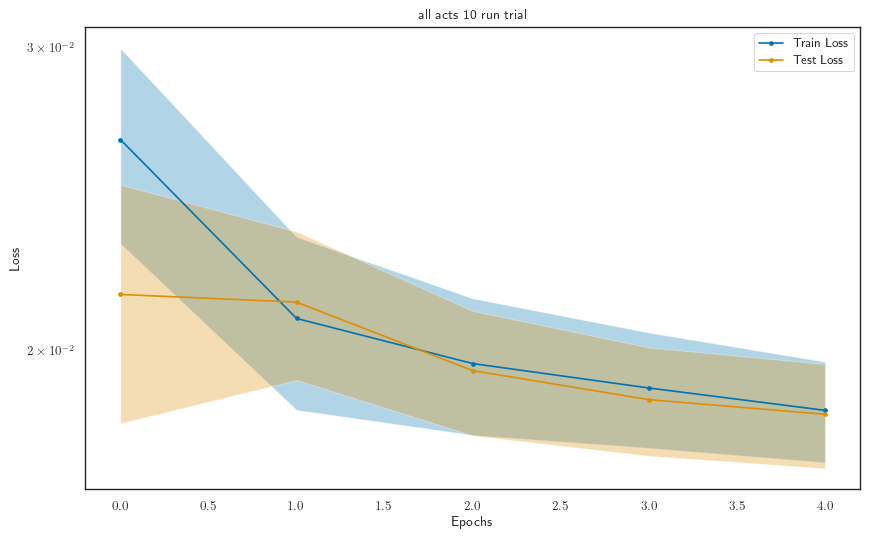

In [18]:
train_losses = jnp.array(train_losses)
test_losses = jnp.array(test_losses)

all_acts = [train_losses, test_losses]

train_mean = all_acts[0].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_mean = all_acts[1].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
train_std = all_acts[0].std(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_std = all_acts[1].std(axis=0).reshape(config.epochs, -1).mean(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_mean, ".-", label="Train Loss")
ax.plot(test_mean, ".-", label="Test Loss")
ax.fill_between(
    np.arange(config.epochs), train_mean - train_std, train_mean + train_std, alpha=0.3
)
ax.fill_between(
    np.arange(config.epochs), test_mean - test_std, test_mean + test_std, alpha=0.3
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_title(f"all acts {runs} run trial")
ax.legend()
plt.savefig(f"{fig_path}/all_acts.png")

In [19]:
### Train inner loop for large epochs and multiple runs for act 1
config.seed = 0

afuncs = [partial(mlp_afunc, model=HNN_acts[0], base_act=jnp.sin)]
train_losses = []
test_losses = []
for i in trange(runs):
    key = jax.random.PRNGKey(config.seed + i)
    model = MultiActMLP(
        config.input_dim, config.output_dim, config.hidden_layer_sizes, key, bias=True
    )
    model = init_linear_weight(model, xavier_normal_init, init_key)
    _, _, inner_results = inner_opt(
        model=model,
        train_data=train_dataloader,
        test_data=test_dataloader,
        afuncs=afuncs,
        opt=opt,
        loss_fn=compute_loss_hnn,
        config=config,
        training=True,
        verbose=False,
    )
    train_losses.append(inner_results.train_loss)
    test_losses.append(inner_results.test_loss)
    logging.info(
        f"Run {i+1 :03d} train loss: {inner_results.train_loss[-1] :.4e} test loss: {inner_results.test_loss[-1] :.4e}"
    )
    del model

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Run 001 train loss: 1.8828e-02 test loss: 2.1516e-02
INFO:root:Run 002 train loss: 1.7624e-02 test loss: 1.5460e-02
INFO:root:Run 003 train loss: 1.8551e-02 test loss: 2.1082e-02
INFO:root:Run 004 train loss: 1.7058e-02 test loss: 1.9251e-02
INFO:root:Run 005 train loss: 1.5669e-02 test loss: 1.7613e-02
INFO:root:Run 006 train loss: 2.0924e-02 test loss: 1.8087e-02
INFO:root:Run 007 train loss: 1.5224e-02 test loss: 2.2905e-02
INFO:root:Run 008 train loss: 1.8525e-02 test loss: 2.0283e-02
INFO:root:Run 009 train loss: 1.8746e-02 test loss: 1.9539e-02
INFO:root:Run 010 train loss: 1.4342e-02 test loss: 1.6509e-02


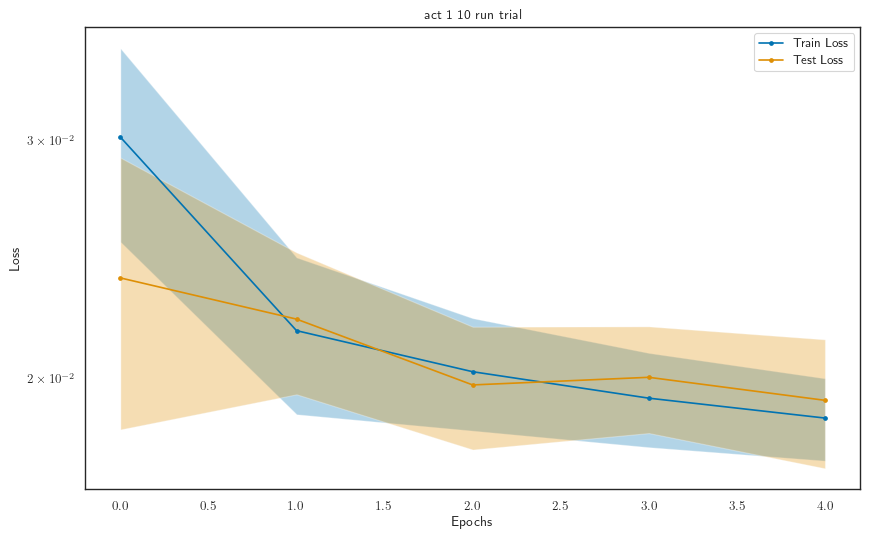

In [20]:
train_losses = jnp.array(train_losses)
test_losses = jnp.array(test_losses)

act_1 = [train_losses, test_losses]

train_mean = act_1[0].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_mean = act_1[1].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
train_std = act_1[0].std(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_std = act_1[1].std(axis=0).reshape(config.epochs, -1).mean(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_mean, ".-", label="Train Loss")
ax.plot(test_mean, ".-", label="Test Loss")
ax.fill_between(
    np.arange(config.epochs), train_mean - train_std, train_mean + train_std, alpha=0.3
)
ax.fill_between(
    np.arange(config.epochs), test_mean - test_std, test_mean + test_std, alpha=0.3
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_title(f"act 1 {runs} run trial")
ax.legend()
plt.savefig(f"{fig_path}/act_1.png")

In [21]:
### Train inner loop for large epochs and multiple runs for act 2
config.seed = 0

afuncs = [partial(mlp_afunc, model=HNN_acts[1], base_act=jnp.sin)]
train_losses = []
test_losses = []
for i in trange(runs):
    key = jax.random.PRNGKey(config.seed + i)
    model = MultiActMLP(
        config.input_dim, config.output_dim, config.hidden_layer_sizes, key, bias=True
    )
    model = init_linear_weight(model, xavier_normal_init, init_key)
    _, _, inner_results = inner_opt(
        model=model,
        train_data=train_dataloader,
        test_data=test_dataloader,
        afuncs=afuncs,
        opt=opt,
        loss_fn=compute_loss_hnn,
        config=config,
        training=True,
        verbose=False,
    )
    train_losses.append(inner_results.train_loss)
    test_losses.append(inner_results.test_loss)
    logging.info(
        f"Run {i+1 :03d} train loss: {inner_results.train_loss[-1] :.4e} test loss: {inner_results.test_loss[-1] :.4e}"
    )
    del model

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Run 001 train loss: 2.2775e-02 test loss: 1.8692e-02
INFO:root:Run 002 train loss: 1.6282e-02 test loss: 2.1730e-02
INFO:root:Run 003 train loss: 1.7425e-02 test loss: 1.7560e-02
INFO:root:Run 004 train loss: 1.9198e-02 test loss: 2.0201e-02
INFO:root:Run 005 train loss: 2.2010e-02 test loss: 1.8376e-02
INFO:root:Run 006 train loss: 1.8822e-02 test loss: 1.8014e-02
INFO:root:Run 007 train loss: 2.0179e-02 test loss: 2.1515e-02
INFO:root:Run 008 train loss: 2.2346e-02 test loss: 1.6650e-02
INFO:root:Run 009 train loss: 2.2456e-02 test loss: 1.8799e-02
INFO:root:Run 010 train loss: 1.4347e-02 test loss: 1.7236e-02


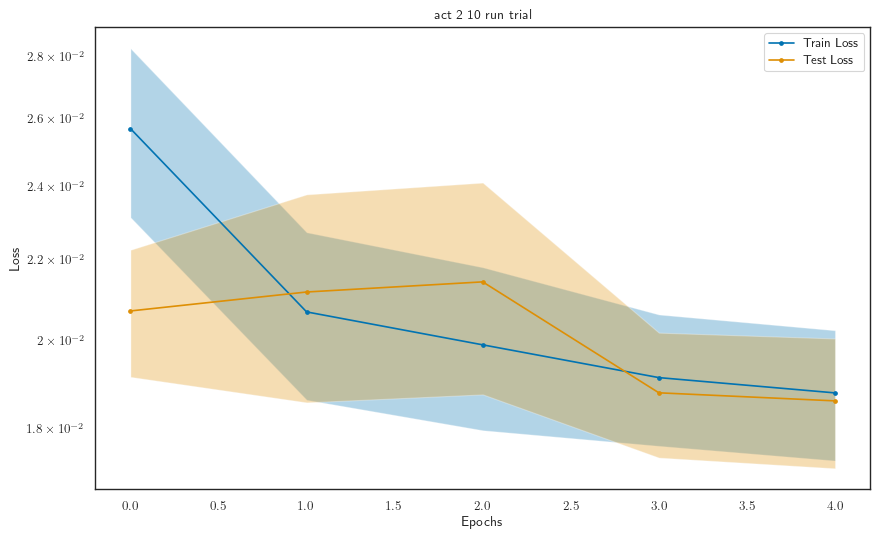

In [22]:
train_losses = jnp.array(train_losses)
test_losses = jnp.array(test_losses)

act_2 = [train_losses, test_losses]

train_mean = act_2[0].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_mean = act_2[1].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
train_std = act_2[0].std(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_std = act_2[1].std(axis=0).reshape(config.epochs, -1).mean(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_mean, ".-", label="Train Loss")
ax.plot(test_mean, ".-", label="Test Loss")
ax.fill_between(
    np.arange(config.epochs), train_mean - train_std, train_mean + train_std, alpha=0.3
)
ax.fill_between(
    np.arange(config.epochs), test_mean - test_std, test_mean + test_std, alpha=0.3
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_title(f"act 2 {runs} run trial")
ax.legend()
plt.savefig(f"{fig_path}/act_2.png")

In [23]:
### Train inner loop for large epochs and multiple runs for sine
config.seed = 0

afuncs = [jnp.sin]
train_losses = []
test_losses = []
for i in trange(runs):
    key = jax.random.PRNGKey(config.seed + i)
    model = MultiActMLP(
        config.input_dim, config.output_dim, config.hidden_layer_sizes, key, bias=True
    )
    model = init_linear_weight(model, xavier_normal_init, init_key)
    _, _, inner_results = inner_opt(
        model=model,
        train_data=train_dataloader,
        test_data=test_dataloader,
        afuncs=afuncs,
        opt=opt,
        loss_fn=compute_loss_hnn,
        config=config,
        training=True,
        verbose=False,
    )
    train_losses.append(inner_results.train_loss)
    test_losses.append(inner_results.test_loss)
    logging.info(
        f"Run {i+1 :03d} train loss: {inner_results.train_loss[-1] :.4e} test loss: {inner_results.test_loss[-1] :.4e}"
    )
    del model

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Run 001 train loss: 2.9508e-02 test loss: 3.1290e-02
INFO:root:Run 002 train loss: 2.6742e-02 test loss: 2.4911e-02
INFO:root:Run 003 train loss: 2.9012e-02 test loss: 5.7972e-02
INFO:root:Run 004 train loss: 2.2200e-02 test loss: 3.2011e-02
INFO:root:Run 005 train loss: 2.1873e-02 test loss: 4.5118e-02
INFO:root:Run 006 train loss: 2.1990e-02 test loss: 4.2478e-02
INFO:root:Run 007 train loss: 3.3273e-02 test loss: 3.0660e-02
INFO:root:Run 008 train loss: 1.9847e-02 test loss: 2.9723e-02
INFO:root:Run 009 train loss: 3.1364e-02 test loss: 2.6339e-02
INFO:root:Run 010 train loss: 2.0988e-02 test loss: 2.8908e-02


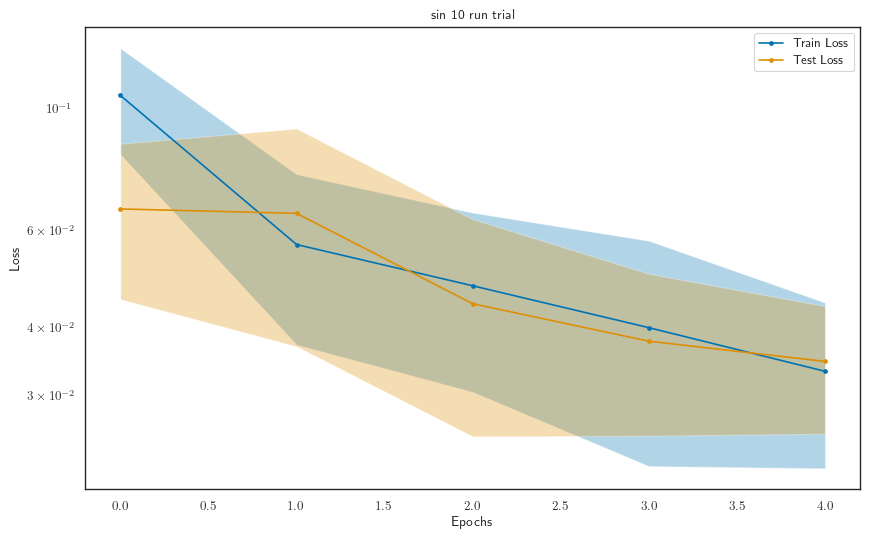

In [24]:
train_losses = jnp.array(train_losses)
test_losses = jnp.array(test_losses)

act_sin = [train_losses, test_losses]

train_mean = act_sin[0].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_mean = act_sin[1].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
train_std = act_sin[0].std(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_std = act_sin[1].std(axis=0).reshape(config.epochs, -1).mean(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_mean, ".-", label="Train Loss")
ax.plot(test_mean, ".-", label="Test Loss")
ax.fill_between(
    np.arange(config.epochs), train_mean - train_std, train_mean + train_std, alpha=0.3
)
ax.fill_between(
    np.arange(config.epochs), test_mean - test_std, test_mean + test_std, alpha=0.3
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_title(f"sin {runs} run trial")
ax.legend()
plt.savefig(f"{fig_path}/act_sin.png")

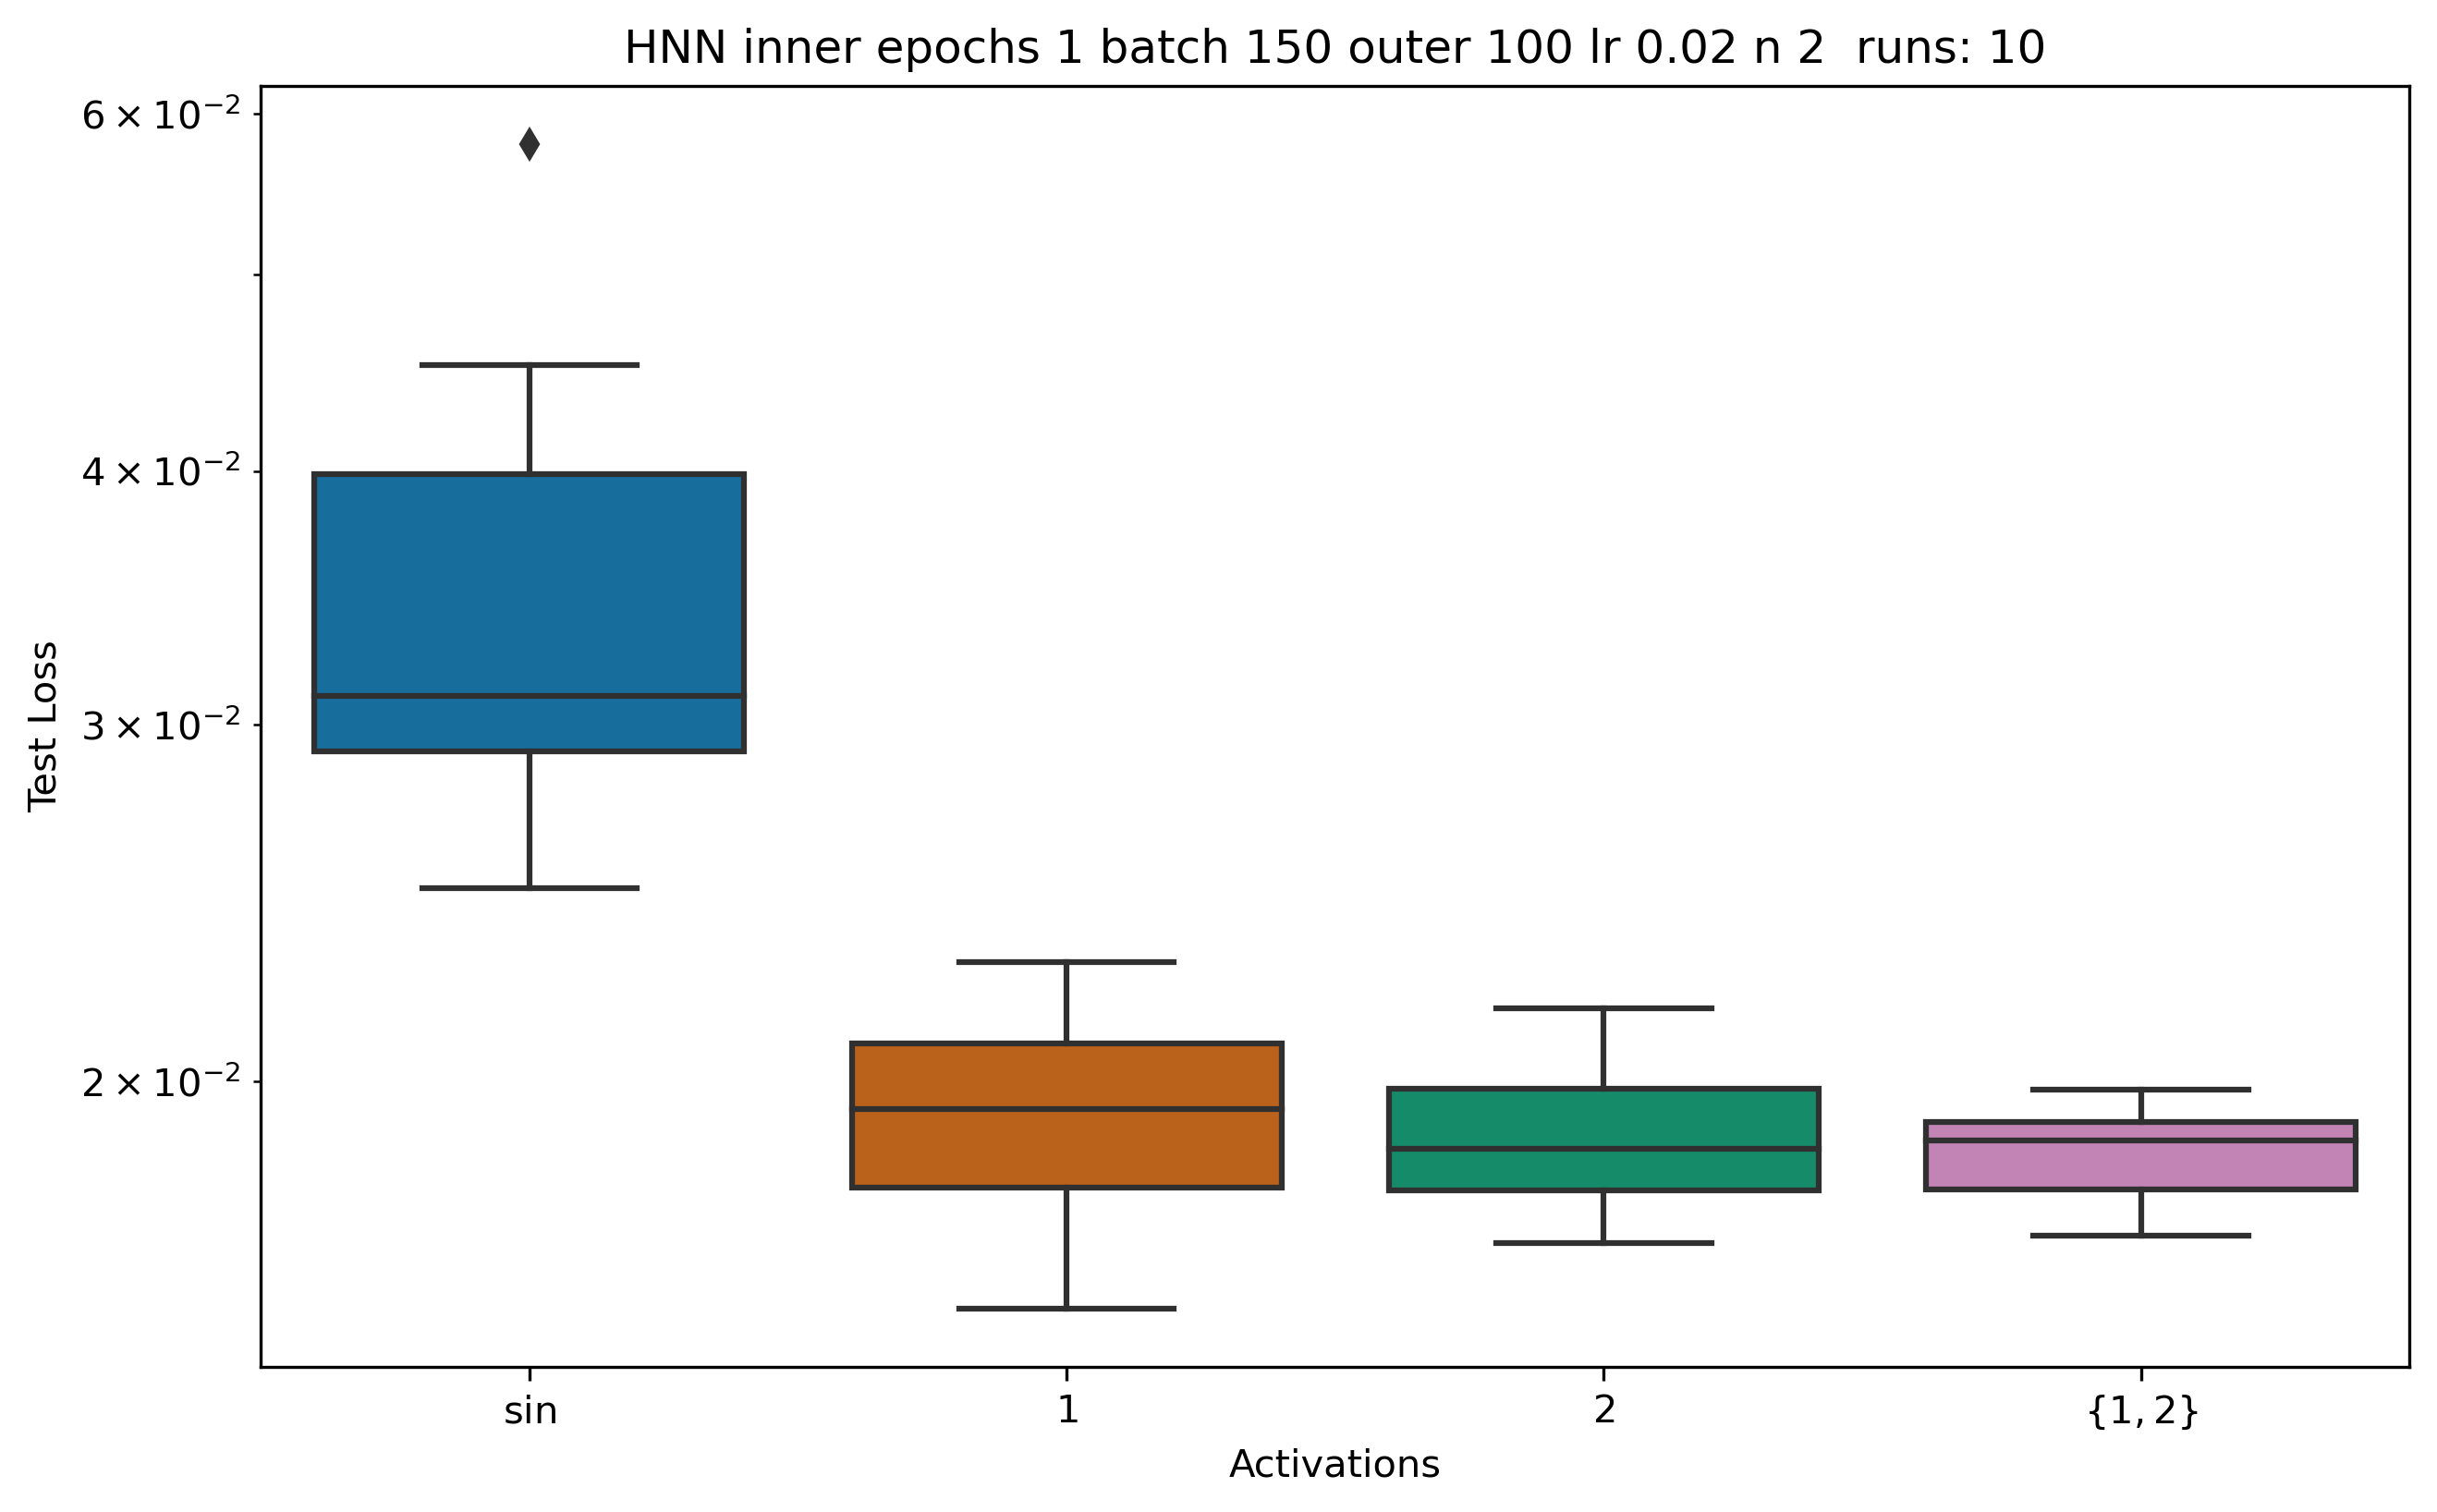

In [25]:
# boxplot using seaborn
plt.style.use("default")
# sns.set_theme(context='paper', style='dark', palette='colorblind', font_scale=1, color_codes=True, rc={'text.usetex' : True})

fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)
sns.boxplot(
    data=[act_sin[1][:, -1], act_1[1][:, -1], act_2[1][:, -1], all_acts[1][:, -1]],
    ax=ax,
    palette=["b", "r", "g", "m"],
)
ax.set_yscale("log")
ax.set_xticklabels(["$\sin$", "$1$", "$2$", "$\{1,2\}$"])
ax.set_ylabel("Test Loss")
ax.set_xlabel("Activations")
ax.set_title(f"{' '.join(description.split('_')[:-2])} " + f" runs: {runs}")
plt.savefig(f"{fig_path}/boxplot.png")
plt.savefig(f"{fig_path}/boxplot.pdf")
plt.show()